# Paradigm 05-1: Patch-Based Iterative Refinement Research Agent

This notebook implements the **Patch-Based Iterative Refinement Architecture** for deep research report generation.

## Core Concept

Unlike traditional Generate-Critique-Revise loops that regenerate the entire document, this architecture:

1. **Decomposes documents into semantic skeleton nodes** with stable identifiers
2. **Generates prose in patches** (per-node expansion) to overcome output token limits
3. **Maintains a claims registry** tracking assertions and their verification status
4. **Applies targeted patches** to specific nodes rather than regenerating everything
5. **Uses bridge sentences** for coherent transitions between sections
6. **Detects cascades** when changes in one section affect dependent sections

## Key Benefits

- **Longer documents**: No output token ceiling, documents can be arbitrarily long
- **Token efficiency**: Only patch sections with issues, not the entire document
- **Better coherence**: Explicit dependency tracking and bridge management
- **Transparency**: Claims registry shows exactly what's verified vs unverified

## Architecture Phases

1. **Skeleton Generation**: Create hierarchical document structure
2. **Node Expansion**: Generate prose for each leaf node
3. **Claim Extraction**: Build registry of assertions
4. **Structured Critique**: Multi-level analysis producing Noise Map
5. **Targeted Retrieval**: Search for evidence for weak claims
6. **Patch Application**: Fix specific nodes, detect cascades
7. **Convergence Check**: Iterate until quality threshold met

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Tracing**: LangSmith
- **Framework**: LangGraph

## 1. Setup and Configuration

In [1]:
import os
import operator
import asyncio
import re
import json
import uuid
from pathlib import Path
from typing import List, Dict, Optional, Annotated, TypedDict, Literal, Any
from dataclasses import dataclass, field

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [2]:
# Initialize LLM and Tavily client
MODEL_NAME = "gpt-5-mini-2025-08-07"
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)
tavily_client = TavilyClient()

# Architecture Configuration
MAX_ITERATIONS = 3          # Maximum critique-patch cycles
QUALITY_THRESHOLD = 7.5     # Stop if quality exceeds this (1-10 scale)
MAX_CASCADES_PER_ITER = 5   # Limit cascade propagation per iteration
TARGET_WORDS_PER_NODE = 300 # Approximate words per leaf node

print(f"Using model: {MODEL_NAME}")
print(f"Max iterations: {MAX_ITERATIONS}")
print(f"Quality threshold: {QUALITY_THRESHOLD}/10")
print(f"Target words per node: {TARGET_WORDS_PER_NODE}")

Using model: gpt-5-mini-2025-08-07
Max iterations: 3
Quality threshold: 7.5/10
Target words per node: 300


## 2. Data Models

### 2.1 Skeleton Structure
The document is organized as a hierarchical tree with stable semantic identifiers.

In [3]:
class SkeletonNode(BaseModel):
    """A node in the document skeleton hierarchy."""
    node_id: str = Field(description="Unique identifier like 'sec:intro' or 'sec:methods:data_collection'")
    title: str = Field(description="Section title for the final document")
    intent: str = Field(description="1-3 sentence description of what this section should accomplish")
    target_word_count: int = Field(default=300, description="Approximate target length")
    dependencies: List[str] = Field(default_factory=list, description="Node IDs this section depends on")
    children: List[str] = Field(default_factory=list, description="Child node IDs (empty for leaf nodes)")
    is_expanded: bool = Field(default=False, description="Whether prose has been generated")


class DocumentSkeleton(BaseModel):
    """The complete document skeleton structure."""
    thesis: str = Field(description="One-sentence statement of the document's central purpose")
    root_nodes: List[str] = Field(description="Top-level section node IDs in document order")
    nodes: Dict[str, SkeletonNode] = Field(default_factory=dict, description="All nodes by ID")
    style_constraints: str = Field(default="", description="Global style guidelines")


# For LLM structured output
class SkeletonGenerationOutput(BaseModel):
    """Output schema for skeleton generation."""
    thesis: str = Field(description="One-sentence thesis statement")
    sections: List[SkeletonNode] = Field(description="All sections in document order")

### 2.2 Prose Store
Content for each node, including bridge sentences for transitions.

In [4]:
class ProseEntry(BaseModel):
    """Content stored for each expanded node."""
    node_id: str = Field(description="The skeleton node this prose belongs to")
    main_content: str = Field(description="The substantive prose for this section")
    bridge_in: str = Field(default="", description="Transitional sentences connecting from previous section")
    bridge_out: str = Field(default="", description="Transitional sentences leading to next section")
    summary: str = Field(default="", description="1-2 sentence compression of content")
    revision_count: int = Field(default=0, description="How many times this node has been revised")
    previous_versions: List[str] = Field(default_factory=list, description="Archive of previous content")


# For LLM structured output when generating prose
class ProseGenerationOutput(BaseModel):
    """Output schema for prose generation."""
    bridge_in: str = Field(description="1-2 transitional sentences connecting from previous section")
    main_content: str = Field(description="The main prose content for this section")
    bridge_out: str = Field(description="1-2 transitional sentences leading to next section")
    summary: str = Field(description="1-2 sentence summary of what this section establishes")

### 2.3 Claims Registry
Tracks every substantive assertion with verification status.

In [5]:
class Claim(BaseModel):
    """A verifiable assertion in the document."""
    claim_id: str = Field(description="Unique identifier for this claim")
    claim_text: str = Field(description="The assertion itself, stated precisely")
    source_node: str = Field(description="Skeleton node ID where this claim appears")
    verification_status: Literal["unverified", "verified", "contested", "retracted"] = Field(
        default="unverified", description="Current verification state"
    )
    supporting_evidence: List[str] = Field(default_factory=list, description="Sources supporting this claim")
    claim_dependencies: List[str] = Field(default_factory=list, description="Other claim IDs this depends on")


# For LLM structured output when extracting claims
class ClaimExtractionOutput(BaseModel):
    """Output schema for claim extraction."""
    claims: List[Claim] = Field(description="All factual claims extracted from the prose")

### 2.4 Critique and Noise Map
Structured feedback targeting specific issues.

In [6]:
class CritiqueIssue(BaseModel):
    """An issue identified during critique."""
    issue_id: str = Field(description="Unique identifier")
    scope: Literal["global", "section", "transition"] = Field(description="Level of the issue")
    target_nodes: List[str] = Field(description="Affected skeleton node IDs")
    issue_type: Literal["weak_claim", "missing_evidence", "logical_gap", "unclear", "coherence", "depth", "transition"] = Field(
        description="Category of issue"
    )
    severity: Literal["critical", "major", "minor"] = Field(description="How serious the issue is")
    affected_claims: List[str] = Field(default_factory=list, description="Claim IDs affected")
    description: str = Field(description="What the problem is")
    suggestion: str = Field(description="How to fix it")
    search_query: str = Field(default="", description="Specific query to find evidence (for evidence issues)")


class CritiqueResult(BaseModel):
    """Complete critique output."""
    overall_quality: float = Field(description="Quality score 1-10")
    issues: List[CritiqueIssue] = Field(default_factory=list, description="All identified issues")
    strengths: str = Field(default="", description="What the document does well")
    summary: str = Field(description="Overall assessment")

## 3. LangGraph State Definition

In [7]:
class PatchBasedRefinementState(TypedDict):
    """State for the Patch-Based Iterative Refinement Agent."""
    # Input
    question: str
    
    # Document Structure (stored as dicts for JSON serialization)
    skeleton: Dict[str, Any]              # DocumentSkeleton as dict
    prose_store: Dict[str, Dict[str, Any]]  # node_id -> ProseEntry as dict
    claims_registry: Dict[str, Dict[str, Any]]  # claim_id -> Claim as dict
    
    # Research & Evidence (accumulated)
    search_results: Annotated[List[str], operator.add]
    source_urls: Annotated[List[str], operator.add]
    
    # Critique & Patching
    noise_map: List[Dict[str, Any]]       # List of CritiqueIssue as dicts
    nodes_to_patch: List[str]             # Node IDs needing revision
    cascade_queue: List[str]              # Nodes needing re-evaluation due to upstream changes
    targeted_evidence: Dict[str, List[str]]  # node_id -> evidence for that node
    
    # Iteration Tracking
    iteration_count: int
    quality_scores: Annotated[List[float], operator.add]
    
    # Logging (accumulated)
    iteration_log: Annotated[List[str], operator.add]
    
    # Output
    final_report: str

## 4. Helper Functions

In [8]:
def search_web(query: str, max_results: int = 8) -> tuple[List[str], List[str]]:
    """Execute web search using Tavily. Returns (results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]
        
        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )
        
        results = []
        urls = []
        
        if response.get("answer"):
            results.append(f"Summary: {response['answer']}")
        
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            results.append(f"- {r.get('title', 'No title')}: {r.get('content', '')[:500]}... (Source: {url})")
        
        return results, urls
    except Exception as e:
        return [f"Search error: {str(e)}"], []


def get_leaf_nodes(skeleton: Dict[str, Any]) -> List[str]:
    """Get all leaf node IDs (nodes without children) in document order."""
    nodes = skeleton.get("nodes", {})
    root_nodes = skeleton.get("root_nodes", [])
    
    def collect_leaves(node_ids: List[str]) -> List[str]:
        leaves = []
        for nid in node_ids:
            node = nodes.get(nid, {})
            children = node.get("children", [])
            if not children:
                leaves.append(nid)
            else:
                leaves.extend(collect_leaves(children))
        return leaves
    
    return collect_leaves(root_nodes)


def topological_sort_nodes(skeleton: Dict[str, Any], node_ids: List[str]) -> List[str]:
    """Sort nodes by dependency order (dependencies before dependents)."""
    nodes = skeleton.get("nodes", {})
    
    # Build dependency graph
    remaining = set(node_ids)
    sorted_nodes = []
    
    while remaining:
        # Find nodes whose dependencies are all satisfied
        ready = []
        for nid in remaining:
            node = nodes.get(nid, {})
            deps = set(node.get("dependencies", []))
            # Check if all dependencies are either not in our set or already processed
            if deps.issubset(set(sorted_nodes) | (set(node_ids) - remaining)):
                ready.append(nid)
        
        if not ready:
            # Circular dependency or missing deps - just add remaining in order
            sorted_nodes.extend(list(remaining))
            break
        
        # Add ready nodes in document order
        ready_ordered = [nid for nid in node_ids if nid in ready]
        sorted_nodes.extend(ready_ordered)
        remaining -= set(ready_ordered)
    
    return sorted_nodes


def get_adjacent_nodes(skeleton: Dict[str, Any], node_id: str) -> tuple[Optional[str], Optional[str]]:
    """Get the previous and next node IDs in document order."""
    leaves = get_leaf_nodes(skeleton)
    try:
        idx = leaves.index(node_id)
        prev_node = leaves[idx - 1] if idx > 0 else None
        next_node = leaves[idx + 1] if idx < len(leaves) - 1 else None
        return prev_node, next_node
    except ValueError:
        return None, None

## 5. Prompts

In [9]:
SKELETON_GENERATION_PROMPT = """You are a research document architect. Create a detailed document skeleton for answering this research question.

Research Question: {question}

Preliminary Research Findings:
{research_findings}

Create a hierarchical document structure with:
1. A clear thesis statement
2. 4-7 main sections appropriate for a comprehensive research report
3. Each section should have:
   - A unique node_id (format: sec:topic or sec:parent:subtopic)
   - A descriptive title
   - An intent describing what the section should accomplish (1-3 sentences)
   - target_word_count (typically 200-400 words per leaf section)
   - dependencies: list of node_ids this section builds upon

Section types to include:
- Introduction (overview and thesis)
- Background/Context (necessary foundation)
- Main body sections (2-4 sections covering key aspects)
- Analysis/Discussion (synthesis and implications)
- Conclusion (summary and future directions)

Ensure dependencies form a directed acyclic graph (no circular dependencies).
"""

PROSE_GENERATION_PROMPT = """You are a research writer generating content for a specific section of a comprehensive report.

DOCUMENT CONTEXT:
Research Question: {question}
Document Thesis: {thesis}

SECTION TO WRITE:
Node ID: {node_id}
Title: {title}
Intent: {intent}
Target Length: ~{target_words} words

DOCUMENT STRUCTURE (for context):
{skeleton_summary}

PREVIOUS SECTION'S ENDING (for smooth transition):
{previous_bridge_out}

CONTENT FROM DEPENDENCY SECTIONS:
{dependency_summaries}

RELEVANT RESEARCH FINDINGS:
{research_findings}

Write this section with:
1. bridge_in: 1-2 sentences connecting from the previous section
2. main_content: The substantive prose (~{target_words} words) addressing the intent
3. bridge_out: 1-2 sentences setting up the next section
4. summary: 1-2 sentence summary of what this section establishes

Include citations where you use the research findings. Be comprehensive and detailed.
"""

CLAIM_EXTRACTION_PROMPT = """Extract all factual claims from this research prose.

Section Node ID: {node_id}

Prose Content:
{prose}

A claim is any statement that:
- Has a truth value (could be verified or refuted)
- Contributes to the document's argument
- Is NOT just a structural statement about the document itself

For each claim, identify:
- claim_id: Unique ID (format: claim_{node_id}_{number})
- claim_text: The precise assertion
- source_node: The node ID ({node_id})
- verification_status: "verified" if it cites a source, "unverified" otherwise
- supporting_evidence: Any cited sources
- claim_dependencies: IDs of claims this one assumes (use claim IDs from earlier sections if applicable)
"""

CRITIQUE_PROMPT = """You are a critical reviewer evaluating a research document section by section.

ORIGINAL QUESTION: {question}

DOCUMENT THESIS: {thesis}

DOCUMENT STRUCTURE:
{skeleton_summary}

CLAIMS REGISTRY (current verification status):
{claims_summary}

FULL DOCUMENT CONTENT:
{document_content}

Analyze this document at three levels:

1. GLOBAL ISSUES (affect entire document):
   - Is the thesis clear and supported?
   - Does the argument flow logically?
   - Is terminology consistent?

2. SECTION ISSUES (per node):
   - Weak claims lacking evidence (MOST IMPORTANT)
   - Missing evidence for key assertions
   - Logical gaps in reasoning
   - Unclear or ambiguous passages
   - Insufficient depth

3. TRANSITION ISSUES (between adjacent nodes):
   - Abrupt topic shifts
   - Redundant transitions
   - Broken references

For EACH issue, specify:
- issue_id: Unique identifier
- scope: "global", "section", or "transition"
- target_nodes: Which node ID(s) are affected
- issue_type: weak_claim, missing_evidence, logical_gap, unclear, coherence, depth, transition
- severity: critical, major, or minor
- affected_claims: Which claim IDs (if applicable)
- description: What the problem is
- suggestion: How to fix it
- search_query: A specific search query to find evidence (for evidence-related issues)

Provide an overall_quality score (1-10) and summary.
"""

PATCH_PROMPT = """You are revising a specific section of a research document based on critique feedback and new evidence.

SECTION TO REVISE:
Node ID: {node_id}
Title: {title}
Intent: {intent}

CURRENT CONTENT:
Bridge In: {current_bridge_in}
Main Content: {current_main_content}
Bridge Out: {current_bridge_out}

ISSUES TO ADDRESS:
{issues_for_node}

NEW EVIDENCE FOUND:
{new_evidence}

CONTEXT FROM ADJACENT SECTIONS:
Previous section ends with: {prev_bridge_out}
Next section starts with: {next_bridge_in}

Revise this section to:
1. Address ALL identified issues
2. Incorporate the new evidence with proper citations
3. Maintain smooth transitions with adjacent sections
4. Keep approximately the same length (don't shorten significantly)

Output the revised:
- bridge_in
- main_content
- bridge_out
- summary
"""

## 6. Node Functions

### 6.1 Phase 1: Preliminary Research & Skeleton Generation

In [10]:
async def preliminary_research(state: PatchBasedRefinementState) -> dict:
    """Conduct lightweight initial research to inform skeleton generation."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Phase 1a: Preliminary Research")
    print(f"{'='*60}")
    
    # Generate 3-4 broad search queries
    query_prompt = f"""Generate 4 search queries to understand the scope of this research question:
    
Question: {question}

Return 4 queries, one per line, covering different aspects."""
    
    response = await llm.ainvoke([HumanMessage(content=query_prompt)])
    queries = [q.strip() for q in response.content.split("\n") if q.strip()][:4]
    
    all_results = []
    all_urls = []
    
    for query in queries:
        print(f"  Searching: {query[:50]}...")
        results, urls = search_web(query, max_results=5)
        all_results.extend(results)
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} preliminary results")
    
    return {
        "search_results": all_results,
        "source_urls": all_urls,
        "iteration_count": 0,
        "iteration_log": [f"Preliminary research: {len(all_results)} results from {len(queries)} queries"]
    }

In [11]:
async def generate_skeleton(state: PatchBasedRefinementState) -> dict:
    """Generate the document skeleton structure."""
    question = state["question"]
    search_results = state.get("search_results", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 1b: Skeleton Generation")
    print(f"{'='*60}")
    
    # Prepare research summary for skeleton generation
    research_summary = "\n".join(search_results[:15])  # Limit context
    
    prompt = SKELETON_GENERATION_PROMPT.format(
        question=question,
        research_findings=research_summary
    )
    
    # Use structured output for skeleton
    structured_llm = llm.with_structured_output(SkeletonGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Build the skeleton dictionary
    skeleton = {
        "thesis": result.thesis,
        "root_nodes": [],
        "nodes": {},
        "style_constraints": "Academic tone, comprehensive analysis, evidence-based claims"
    }
    
    for section in result.sections:
        skeleton["nodes"][section.node_id] = section.model_dump()
        # Track root nodes (those without a parent reference in their ID)
        if section.node_id.count(":") == 1:  # e.g., "sec:intro" not "sec:intro:subsection"
            skeleton["root_nodes"].append(section.node_id)
    
    # If no root nodes detected, use all as roots
    if not skeleton["root_nodes"]:
        skeleton["root_nodes"] = list(skeleton["nodes"].keys())
    
    print(f"  Thesis: {result.thesis[:100]}...")
    print(f"  Generated {len(skeleton['nodes'])} skeleton nodes:")
    for nid, node in skeleton["nodes"].items():
        print(f"    - {nid}: {node['title']}")
    
    return {
        "skeleton": skeleton,
        "prose_store": {},
        "claims_registry": {},
        "iteration_log": [f"Skeleton generated with {len(skeleton['nodes'])} nodes"]
    }

### 6.2 Phase 2: Node Expansion (Prose Generation)

In [12]:
async def expand_single_node(
    node_id: str,
    skeleton: Dict[str, Any],
    prose_store: Dict[str, Dict[str, Any]],
    search_results: List[str],
    question: str
) -> Dict[str, Any]:
    """Generate prose for a single skeleton node."""
    node = skeleton["nodes"][node_id]
    leaves = get_leaf_nodes(skeleton)
    
    # Get previous node's bridge_out for transition
    prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
    prev_bridge_out = ""
    if prev_node and prev_node in prose_store:
        prev_bridge_out = prose_store[prev_node].get("bridge_out", "")
    
    # Get dependency summaries
    dependency_summaries = []
    for dep_id in node.get("dependencies", []):
        if dep_id in prose_store:
            dep_summary = prose_store[dep_id].get("summary", "")
            dep_title = skeleton["nodes"].get(dep_id, {}).get("title", dep_id)
            dependency_summaries.append(f"{dep_title}: {dep_summary}")
    
    # Build skeleton summary for context
    skeleton_summary = "\n".join([
        f"- {nid}: {skeleton['nodes'][nid]['title']}" 
        for nid in leaves
    ])
    
    # Select relevant research findings (limit tokens)
    relevant_findings = "\n".join(search_results[:10])
    
    prompt = PROSE_GENERATION_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        node_id=node_id,
        title=node.get("title", ""),
        intent=node.get("intent", ""),
        target_words=node.get("target_word_count", TARGET_WORDS_PER_NODE),
        skeleton_summary=skeleton_summary,
        previous_bridge_out=prev_bridge_out if prev_bridge_out else "(This is the first section)",
        dependency_summaries="\n".join(dependency_summaries) if dependency_summaries else "(No dependencies)",
        research_findings=relevant_findings
    )
    
    structured_llm = llm.with_structured_output(ProseGenerationOutput)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    return {
        "node_id": node_id,
        "main_content": result.main_content,
        "bridge_in": result.bridge_in,
        "bridge_out": result.bridge_out,
        "summary": result.summary,
        "revision_count": 0,
        "previous_versions": []
    }


async def expand_all_nodes(state: PatchBasedRefinementState) -> dict:
    """Expand all leaf nodes in dependency order."""
    skeleton = state["skeleton"]
    search_results = state.get("search_results", [])
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Phase 2: Node Expansion")
    print(f"{'='*60}")
    
    # Get leaf nodes in dependency order
    leaf_nodes = get_leaf_nodes(skeleton)
    sorted_nodes = topological_sort_nodes(skeleton, leaf_nodes)
    
    prose_store = {}
    
    for i, node_id in enumerate(sorted_nodes):
        node = skeleton["nodes"][node_id]
        print(f"  [{i+1}/{len(sorted_nodes)}] Expanding: {node_id} - {node['title']}")
        
        prose_entry = await expand_single_node(
            node_id=node_id,
            skeleton=skeleton,
            prose_store=prose_store,
            search_results=search_results,
            question=question
        )
        prose_store[node_id] = prose_entry
        
        # Mark as expanded in skeleton
        skeleton["nodes"][node_id]["is_expanded"] = True
        
        print(f"      Generated {len(prose_entry['main_content'])} chars")
    
    return {
        "skeleton": skeleton,
        "prose_store": prose_store,
        "iteration_log": [f"Expanded {len(sorted_nodes)} nodes"]
    }

### 6.3 Phase 3: Claim Extraction

In [13]:
async def extract_claims(state: PatchBasedRefinementState) -> dict:
    """Extract claims from all prose and build the claims registry."""
    prose_store = state["prose_store"]
    
    print(f"\n{'='*60}")
    print(f"Phase 3: Claim Extraction")
    print(f"{'='*60}")
    
    claims_registry = {}
    structured_llm = llm.with_structured_output(ClaimExtractionOutput)
    
    for node_id, prose_entry in prose_store.items():
        print(f"  Extracting claims from: {node_id}")
        
        full_prose = f"{prose_entry.get('bridge_in', '')}\n{prose_entry.get('main_content', '')}\n{prose_entry.get('bridge_out', '')}"
        
        prompt = CLAIM_EXTRACTION_PROMPT.format(
            node_id=node_id,
            prose=full_prose
        )
        
        try:
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            for claim in result.claims:
                claims_registry[claim.claim_id] = claim.model_dump()
            
            print(f"    Found {len(result.claims)} claims")
        except Exception as e:
            print(f"    Error extracting claims: {e}")
    
    # Count verification status
    verified = sum(1 for c in claims_registry.values() if c.get("verification_status") == "verified")
    unverified = sum(1 for c in claims_registry.values() if c.get("verification_status") == "unverified")
    
    print(f"  Total claims: {len(claims_registry)} ({verified} verified, {unverified} unverified)")
    
    return {
        "claims_registry": claims_registry,
        "iteration_log": [f"Extracted {len(claims_registry)} claims ({verified} verified, {unverified} unverified)"]
    }

### 6.4 Phase 4: Structured Critique

In [14]:
async def critique_document(state: PatchBasedRefinementState) -> dict:
    """Perform multi-level critique producing the Noise Map."""
    skeleton = state["skeleton"]
    prose_store = state["prose_store"]
    claims_registry = state.get("claims_registry", {})
    question = state["question"]
    iteration_count = state.get("iteration_count", 0)
    
    print(f"\n{'='*60}")
    print(f"Phase 4: Structured Critique (Iteration {iteration_count})")
    print(f"{'='*60}")
    
    # Build skeleton summary
    leaf_nodes = get_leaf_nodes(skeleton)
    skeleton_summary = "\n".join([
        f"- {nid}: {skeleton['nodes'][nid]['title']}" 
        for nid in leaf_nodes
    ])
    
    # Build claims summary
    claims_summary = "\n".join([
        f"- [{c['verification_status']}] {c['claim_id']}: {c['claim_text'][:80]}..."
        for c in list(claims_registry.values())[:20]  # Limit to avoid token overflow
    ])
    
    # Build full document content
    document_content = ""
    for node_id in leaf_nodes:
        if node_id in prose_store:
            node = skeleton["nodes"][node_id]
            prose = prose_store[node_id]
            document_content += f"\n\n## {node['title']} [{node_id}]\n"
            document_content += f"{prose.get('bridge_in', '')}\n"
            document_content += f"{prose.get('main_content', '')}\n"
            document_content += f"{prose.get('bridge_out', '')}\n"
    
    # Truncate if too long
    if len(document_content) > 15000:
        document_content = document_content[:15000] + "\n\n[... truncated for critique ...]\n"
    
    prompt = CRITIQUE_PROMPT.format(
        question=question,
        thesis=skeleton.get("thesis", ""),
        skeleton_summary=skeleton_summary,
        claims_summary=claims_summary if claims_summary else "(No claims extracted yet)",
        document_content=document_content
    )
    
    structured_llm = llm.with_structured_output(CritiqueResult)
    result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
    
    # Convert issues to dicts for state storage
    noise_map = [issue.model_dump() for issue in result.issues]
    
    # Identify nodes that need patching (have issues)
    nodes_to_patch = list(set(
        node_id 
        for issue in result.issues 
        for node_id in issue.target_nodes
        if issue.severity in ["critical", "major"]
    ))
    
    print(f"  Quality Score: {result.overall_quality}/10")
    print(f"  Issues found: {len(result.issues)}")
    print(f"    - Critical: {sum(1 for i in result.issues if i.severity == 'critical')}")
    print(f"    - Major: {sum(1 for i in result.issues if i.severity == 'major')}")
    print(f"    - Minor: {sum(1 for i in result.issues if i.severity == 'minor')}")
    print(f"  Nodes to patch: {nodes_to_patch}")
    
    return {
        "noise_map": noise_map,
        "nodes_to_patch": nodes_to_patch,
        "quality_scores": [result.overall_quality],
        "iteration_log": [f"Critique: {result.overall_quality}/10, {len(result.issues)} issues, {len(nodes_to_patch)} nodes to patch"]
    }

### 6.5 Phase 5: Targeted Retrieval

In [15]:
async def targeted_retrieval(state: PatchBasedRefinementState) -> dict:
    """Search for evidence to address specific issues in the Noise Map."""
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    
    print(f"\n{'='*60}")
    print(f"Phase 5: Targeted Retrieval")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No nodes need patching - skipping retrieval")
        return {
            "targeted_evidence": {},
            "search_results": [],
            "source_urls": []
        }
    
    # Collect search queries for each node from issues
    node_queries = {}  # node_id -> list of search queries
    for issue in noise_map:
        if issue.get("search_query") and issue.get("severity") in ["critical", "major"]:
            for node_id in issue.get("target_nodes", []):
                if node_id in nodes_to_patch:
                    if node_id not in node_queries:
                        node_queries[node_id] = []
                    node_queries[node_id].append(issue["search_query"])
    
    targeted_evidence = {}  # node_id -> list of evidence strings
    all_results = []
    all_urls = []
    
    for node_id, queries in node_queries.items():
        print(f"  Researching for node: {node_id}")
        node_evidence = []
        
        # Limit queries per node
        for query in queries[:3]:
            print(f"    Query: {query[:50]}...")
            results, urls = search_web(query, max_results=5)
            node_evidence.extend(results)
            all_results.extend(results)
            all_urls.extend(urls)
        
        targeted_evidence[node_id] = node_evidence
        print(f"    Found {len(node_evidence)} results")
    
    print(f"  Total new evidence: {len(all_results)} results")
    
    return {
        "targeted_evidence": targeted_evidence,
        "search_results": all_results,
        "source_urls": all_urls,
        "iteration_log": [f"Targeted retrieval: {len(all_results)} results for {len(node_queries)} nodes"]
    }

### 6.6 Phase 6: Patch Application

In [16]:
async def apply_patches(state: PatchBasedRefinementState) -> dict:
    """Apply targeted patches to nodes with issues."""
    skeleton = state["skeleton"]
    prose_store = state["prose_store"]
    claims_registry = state.get("claims_registry", {})
    noise_map = state.get("noise_map", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    targeted_evidence = state.get("targeted_evidence", {})
    iteration_count = state.get("iteration_count", 0)
    
    print(f"\n{'='*60}")
    print(f"Phase 6: Patch Application")
    print(f"{'='*60}")
    
    if not nodes_to_patch:
        print("  No patches to apply")
        return {
            "prose_store": prose_store,
            "cascade_queue": [],
            "iteration_count": iteration_count + 1
        }
    
    # Sort nodes by dependency order
    sorted_patch_nodes = topological_sort_nodes(skeleton, nodes_to_patch)
    cascade_queue = []
    
    structured_llm = llm.with_structured_output(ProseGenerationOutput)
    
    for node_id in sorted_patch_nodes:
        if node_id not in prose_store:
            continue
            
        node = skeleton["nodes"].get(node_id, {})
        current_prose = prose_store[node_id]
        
        print(f"  Patching: {node_id} - {node.get('title', '')}")
        
        # Collect issues for this node
        node_issues = [
            issue for issue in noise_map 
            if node_id in issue.get("target_nodes", [])
        ]
        issues_text = "\n".join([
            f"- [{i.get('severity', '')}] {i.get('issue_type', '')}: {i.get('description', '')}\n  Suggestion: {i.get('suggestion', '')}"
            for i in node_issues
        ])
        
        # Get evidence for this node
        node_evidence = targeted_evidence.get(node_id, [])
        evidence_text = "\n".join(node_evidence) if node_evidence else "No additional evidence found."
        
        # Get adjacent section context
        prev_node, next_node = get_adjacent_nodes(skeleton, node_id)
        prev_bridge_out = ""
        next_bridge_in = ""
        if prev_node and prev_node in prose_store:
            prev_bridge_out = prose_store[prev_node].get("bridge_out", "")
        if next_node and next_node in prose_store:
            next_bridge_in = prose_store[next_node].get("bridge_in", "")
        
        prompt = PATCH_PROMPT.format(
            node_id=node_id,
            title=node.get("title", ""),
            intent=node.get("intent", ""),
            current_bridge_in=current_prose.get("bridge_in", ""),
            current_main_content=current_prose.get("main_content", ""),
            current_bridge_out=current_prose.get("bridge_out", ""),
            issues_for_node=issues_text,
            new_evidence=evidence_text[:6000],  # Limit evidence length
            prev_bridge_out=prev_bridge_out if prev_bridge_out else "(First section)",
            next_bridge_in=next_bridge_in if next_bridge_in else "(Last section)"
        )
        
        try:
            result = await structured_llm.ainvoke([HumanMessage(content=prompt)])
            
            # Archive previous version
            previous_versions = current_prose.get("previous_versions", [])
            previous_versions.append(current_prose.get("main_content", ""))
            
            # Update prose store with patch
            prose_store[node_id] = {
                "node_id": node_id,
                "main_content": result.main_content,
                "bridge_in": result.bridge_in,
                "bridge_out": result.bridge_out,
                "summary": result.summary,
                "revision_count": current_prose.get("revision_count", 0) + 1,
                "previous_versions": previous_versions[-3:]  # Keep last 3 versions
            }
            
            print(f"    Patched: {len(result.main_content)} chars (revision #{prose_store[node_id]['revision_count']})")
            
            # Check for cascades - find nodes that depend on this one
            for other_id, other_node in skeleton["nodes"].items():
                if node_id in other_node.get("dependencies", []) and other_id not in nodes_to_patch:
                    if other_id not in cascade_queue:
                        cascade_queue.append(other_id)
                        print(f"    Cascade detected: {other_id} depends on patched node")
            
        except Exception as e:
            print(f"    Error patching {node_id}: {e}")
    
    # Limit cascade queue
    cascade_queue = cascade_queue[:MAX_CASCADES_PER_ITER]
    
    print(f"  Patched {len(sorted_patch_nodes)} nodes")
    print(f"  Cascade queue: {cascade_queue}")
    
    return {
        "prose_store": prose_store,
        "cascade_queue": cascade_queue,
        "iteration_count": iteration_count + 1,
        "iteration_log": [f"Patched {len(sorted_patch_nodes)} nodes, {len(cascade_queue)} cascades queued"]
    }

### 6.7 Phase 7: Convergence Check

In [17]:
def should_continue_refining(state: PatchBasedRefinementState) -> Literal["targeted_retrieval", "assemble"]:
    """Decide whether to continue refinement or finalize."""
    iteration_count = state.get("iteration_count", 0)
    quality_scores = state.get("quality_scores", [])
    nodes_to_patch = state.get("nodes_to_patch", [])
    cascade_queue = state.get("cascade_queue", [])
    
    latest_score = quality_scores[-1] if quality_scores else 0
    
    print(f"\n--- Convergence Check ---")
    print(f"  Iteration: {iteration_count}/{MAX_ITERATIONS}")
    print(f"  Quality: {latest_score}/{QUALITY_THRESHOLD}")
    print(f"  Nodes to patch: {len(nodes_to_patch)}")
    print(f"  Cascade queue: {len(cascade_queue)}")
    
    # Convergence conditions
    if iteration_count >= MAX_ITERATIONS:
        print(f"  -> Max iterations reached. Finalizing.")
        return "assemble"
    
    if latest_score >= QUALITY_THRESHOLD:
        print(f"  -> Quality threshold met. Finalizing.")
        return "assemble"
    
    if not nodes_to_patch and not cascade_queue:
        print(f"  -> No issues to address. Finalizing.")
        return "assemble"
    
    print(f"  -> Continuing refinement.")
    return "targeted_retrieval"

### 6.8 Final Assembly

In [18]:
async def assemble_document(state: PatchBasedRefinementState) -> dict:
    """Assemble the final document from all prose entries."""
    skeleton = state["skeleton"]
    prose_store = state["prose_store"]
    claims_registry = state.get("claims_registry", {})
    quality_scores = state.get("quality_scores", [])
    iteration_count = state.get("iteration_count", 0)
    source_urls = state.get("source_urls", [])
    
    print(f"\n{'='*60}")
    print(f"Final Assembly")
    print(f"{'='*60}")
    
    # Get leaf nodes in document order
    leaf_nodes = get_leaf_nodes(skeleton)
    
    # Build document
    document_parts = []
    
    # Title
    document_parts.append(f"# Research Report\n")
    document_parts.append(f"**Thesis:** {skeleton.get('thesis', '')}\n\n")
    
    # Sections
    for node_id in leaf_nodes:
        if node_id not in prose_store:
            continue
            
        node = skeleton["nodes"].get(node_id, {})
        prose = prose_store[node_id]
        
        # Section header
        document_parts.append(f"## {node.get('title', node_id)}\n\n")
        
        # Content (bridge_in flows naturally)
        if prose.get("bridge_in"):
            document_parts.append(f"{prose['bridge_in']} ")
        document_parts.append(f"{prose.get('main_content', '')}")
        if prose.get("bridge_out"):
            document_parts.append(f" {prose['bridge_out']}")
        document_parts.append("\n\n")
    
    # References section
    unique_urls = list(set(source_urls))
    if unique_urls:
        document_parts.append("## References\n\n")
        for i, url in enumerate(unique_urls[:20], 1):  # Limit to 20 refs
            document_parts.append(f"{i}. {url}\n")
    
    final_report = "".join(document_parts)
    
    # Stats
    word_count = len(final_report.split())
    verified_claims = sum(1 for c in claims_registry.values() if c.get("verification_status") == "verified")
    total_claims = len(claims_registry)
    
    print(f"  Document length: {len(final_report)} chars ({word_count} words)")
    print(f"  Sections: {len(leaf_nodes)}")
    print(f"  Total iterations: {iteration_count}")
    print(f"  Quality progression: {' -> '.join([f'{s:.1f}' for s in quality_scores])}")
    print(f"  Claims: {verified_claims}/{total_claims} verified")
    print(f"  Sources: {len(unique_urls)}")
    
    return {
        "final_report": final_report,
        "iteration_log": [f"Assembled: {word_count} words, {len(leaf_nodes)} sections, {len(unique_urls)} sources"]
    }

## 7. Graph Construction

In [19]:
# Build the Patch-Based Iterative Refinement Agent graph
#
# Flow:
#   START -> preliminary_research -> generate_skeleton -> expand_all_nodes -> extract_claims
#                                                                                  |
#                                                                                  v
#                                                                           critique_document
#                                                                                  |
#                         +--------------------------------------------------------+
#                         |                                                        |
#                         v                                                        v
#                  targeted_retrieval                                      assemble_document -> END
#                         |                                               (if converged)
#                         v
#                   apply_patches
#                         |
#                         v
#                  critique_document (loop back)

builder = StateGraph(PatchBasedRefinementState)

# Add nodes
builder.add_node("preliminary_research", preliminary_research)
builder.add_node("generate_skeleton", generate_skeleton)
builder.add_node("expand_all_nodes", expand_all_nodes)
builder.add_node("extract_claims", extract_claims)
builder.add_node("critique_document", critique_document)
builder.add_node("targeted_retrieval", targeted_retrieval)
builder.add_node("apply_patches", apply_patches)
builder.add_node("assemble_document", assemble_document)

# Add edges - Initial flow
builder.add_edge(START, "preliminary_research")
builder.add_edge("preliminary_research", "generate_skeleton")
builder.add_edge("generate_skeleton", "expand_all_nodes")
builder.add_edge("expand_all_nodes", "extract_claims")
builder.add_edge("extract_claims", "critique_document")

# Conditional edge: continue refining or finalize
builder.add_conditional_edges(
    "critique_document",
    should_continue_refining,
    {
        "targeted_retrieval": "targeted_retrieval",
        "assemble": "assemble_document"
    }
)

# Refinement loop
builder.add_edge("targeted_retrieval", "apply_patches")
builder.add_edge("apply_patches", "critique_document")

# Final
builder.add_edge("assemble_document", END)

# Compile
patch_refinement_graph = builder.compile()

print("Patch-Based Iterative Refinement Agent compiled successfully")
print("\nKey features:")
print("  - Skeleton-based document structure with semantic addressing")
print("  - Per-node prose generation (patches, not full regeneration)")
print("  - Claims registry for tracking verification status")
print("  - Targeted retrieval for specific weak claims")
print("  - Cascade detection when patches affect dependent sections")

Patch-Based Iterative Refinement Agent compiled successfully

Key features:
  - Skeleton-based document structure with semantic addressing
  - Per-node prose generation (patches, not full regeneration)
  - Claims registry for tracking verification status
  - Targeted retrieval for specific weak claims
  - Cascade detection when patches affect dependent sections


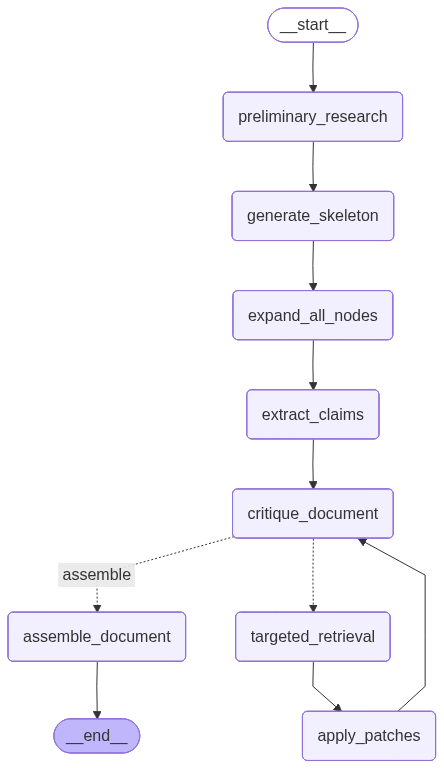

In [20]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(patch_refinement_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 8. Agent Wrapper for Evaluation

In [ ]:
async def patch_refinement_agent_async(inputs: dict) -> dict:
    """
    Async version of the Patch-Based Iterative Refinement research agent.
    Use this version when calling from Jupyter notebooks.
    """
    question = inputs.get("question", "")
    
    result = await patch_refinement_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 100}
    )
    
    return {
        "output": result.get("final_report", ""),
        "iteration_count": result.get("iteration_count", 0),
        "quality_scores": result.get("quality_scores", []),
        "source_urls": result.get("source_urls", []),
        "skeleton": result.get("skeleton", {}),
        "claims_registry": result.get("claims_registry", {})
    }


def patch_refinement_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Patch-Based Iterative Refinement research agent.
    
    Compatible with evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key
        
    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")
    
    async def _execute():
        return await patch_refinement_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 100}
        )
    
    # Check if we're already in an async context (e.g., Jupyter notebook)
    try:
        loop = asyncio.get_running_loop()
        # We're in an event loop - need to run in a separate thread
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        # No event loop running, safe to use asyncio.run
        result = asyncio.run(_execute())
    
    return {
        "output": result.get("final_report", ""),
        "iteration_count": result.get("iteration_count", 0),
        "quality_scores": result.get("quality_scores", []),
        "source_urls": result.get("source_urls", [])
    }

## 9. Manual Test

Run this cell to verify the agent works correctly with a simple test question.

In [ ]:
# Simple test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Patch-Based Iterative Refinement Agent")
print(f"Question: {test_question}")
print("\nRunning patch-based research (this may take several minutes)...\n")

try:
    # Use the async version in notebooks to avoid event loop conflicts
    result = await patch_refinement_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:4000] + "..." if len(result["output"]) > 4000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Total iterations: {result.get('iteration_count', 0)}")
    print(f"Quality progression: {result.get('quality_scores', [])}")
    print(f"Unique sources: {len(set(result.get('source_urls', [])))}")
    print(f"Skeleton nodes: {len(result.get('skeleton', {}).get('nodes', {}))}")
    print(f"Claims tracked: {len(result.get('claims_registry', {}))}")
    print("Agent test PASSED")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

## 10. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness, 
    fact_recall, 
    citation_precision,
    coherence_judge, 
    depth_judge, 
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

In [ ]:
# Full Evaluation on All 20 Questions
# Uncomment to run:

# # Define comprehensive evaluator suite
# evaluators = [
#     fact_recall,              # Required facts coverage
#     citation_precision,       # Citation URL validity
#     minimum_sources_check,    # Minimum source count
#     coherence_judge,          # Logical structure
#     depth_judge,              # Analysis depth
#     relevance_judge,          # Addresses question
# ]
# 
# # Run full evaluation
# print("Starting FULL evaluation on all 20 questions...")
# print("Patch-Based Iterative Refinement Agent - this will take 1-2 hours.")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=patch_refinement_agent,
#     evaluators=evaluators,
#     experiment_name="patch_refinement_v1",
#     monte_carlo_runs=1,  # Single run to reduce cost
#     max_concurrency=2,   # Lower concurrency for stability
#     description="Patch-Based Iterative Refinement paradigm evaluation"
# )
# 
# # Display comprehensive results
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
# print(f"Runs per question: {results.num_runs}")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric_name in sorted(results.metrics.keys()):
#     if not metric_name.endswith('_std'):
#         value = results.metrics.get(metric_name, 0)
#         print(f"{metric_name:<30} {value:<10.3f}")
# 
# # Save results to file
# import json
# from datetime import datetime
# 
# results_file = Path("../results") / f"patch_refinement_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
# results_file.parent.mkdir(exist_ok=True)
# 
# with open(results_file, 'w') as f:
#     json.dump({
#         "experiment_name": results.experiment_name,
#         "num_questions": results.num_questions,
#         "num_runs": results.num_runs,
#         "metrics": results.metrics,
#         "per_question": results.per_question_results
#     }, f, indent=2)
# 
# print(f"\nResults saved to: {results_file}")

print("Full evaluation cell ready. Uncomment to run when ready.")

## 11. Architecture Comparison

### Original Approach (Full Regeneration)
- Generate complete draft (~1500 tokens)
- Critique and identify issues
- Regenerate ENTIRE draft (~1500 tokens) per iteration
- Token cost: ~1500 + 1500*N iterations

### Patch-Based Approach
- Generate skeleton (~300 tokens)
- Expand each node (~300 tokens * 5-7 nodes = ~1800 tokens)
- Critique identifies specific nodes needing fixes
- Patch ONLY affected nodes (~300 tokens per patched node)
- Token cost: 300 + 1800 + 300*patches per iteration

### Benefits
1. **Longer documents**: No output token limit since we generate in chunks
2. **Token efficiency**: If 2/6 nodes need fixing, we regenerate ~600 tokens instead of 1800
3. **Better targeting**: Claims registry tracks exactly what needs verification
4. **Coherence**: Bridge sentences ensure smooth transitions
5. **Transparency**: Skeleton shows document structure, claims show verification status